### **Imports**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

from keras import models
from keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## **1. Reading Toxic Comments Dataset**

In [3]:
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification/train.csv', index_col='id')
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification/test.csv', index_col='id')
test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification/test_labels.csv', index_col='id')

In [4]:
test_df = pd.concat([test_df, test_labels], axis=1)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153164 entries, 00001cee341fdb12 to ffffce3fb183ee80
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   153164 non-null  object
 1   toxic          153164 non-null  int64 
 2   severe_toxic   153164 non-null  int64 
 3   obscene        153164 non-null  int64 
 4   threat         153164 non-null  int64 
 5   insult         153164 non-null  int64 
 6   identity_hate  153164 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.3+ MB


## **2. EDA**

#### **2.1 Show a sample of data**
(to find out the required text preprocessing steps)

In [7]:
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [8]:
test_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",-1,-1,-1,-1,-1,-1
0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO.",-1,-1,-1,-1,-1,-1
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """,-1,-1,-1,-1,-1,-1
00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.",-1,-1,-1,-1,-1,-1
00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


#### **2.2 Check for duplicates**

In [9]:
train_df.duplicated().sum()

0

In [10]:
train_df.duplicated(subset=['comment_text']).sum()

0

In [11]:
test_df.duplicated().sum()

0

#### **2.3 Check for URLs**

In [12]:
train_df.comment_text.str.findall(r'https?:\/\/\S*').drop_duplicates(keep=False)

id
000c0dfd995809fa                                                                                                                                                                                       [http://www.its.caltech.edu/~atomic/snowcrystals/myths/myths.htm#perfection]
001363e1dbe91225                                                                                                                                                                                               [http://digg.com/music/Wikipedia_has_free_classical_music_downloads]
002c9cccf2f1d05b                                                                                                                                        [http://www.constitution.ie/reports/ConstitutionofIreland.pdf, http://www.constitution.ie/reports/mbunreachtnaheireann.pdf]
0038f191ffc93d75                                                                                                                                                         

#### **2.4 Check for Emails and mentions**

In [13]:
train_df.comment_text.str.findall(r'\S*@\S+').drop_duplicates(keep=False)

id
0236f714de182059                      [apriljohnson6868@gmail.com]
03585d8dd27a3653                            [animeking237@aol.com]
055c9cafcdb359f9    [bathory@bathory.org, bathory@maltedmedia.com]
05ee06363d9dda77                                  [jeff@fugly.com]
0675ca47f054c2c0                                           [@Matt]
                                         ...                      
ea17eecb83be13ee                             [manasgarg@gmail.com]
ee831c8c79c9984f                                         [@'''''']
ef12914c33ab46b5                                     [@Powergate:]
f1ac66faba2e5bae                             [@Tznkai:, @Snowman:]
f5379a104a9276a2                                 [last@yourhouse.]
Name: comment_text, Length: 621, dtype: object

#### **2.5 Check for Hashtags**

In [14]:
train_df.comment_text.str.findall(r'#\S+').drop_duplicates(keep=False)

id
0001b41b1c6bb37e                                                                                                                                                [#Transport]
000c0dfd995809fa                                                                                                                                               [#perfection]
001363e1dbe91225    [#Need_help.21Wikipedia_talk:WikiProject_Music/Archive_3#I_could_use_some_helpWikipedia_talk:WikiProject_Music/Archive_2#Raulbot.2C_and_the_music_list)]
003b9f448ee4a29d                                                                                             [#WP:V_-_comparing_Jewish_Virtual_Library_and_Dissident_Voice.]
00585c1da10b448b                                                                                                                                                    [#5-5-5]
                                                                                              ...                                   

#### **2.6 Check for HTML tags**

In [15]:
train_df.comment_text.str.findall(r'<.*>').drop_duplicates(keep=False)

id
0e343b7f449df75a                                                                                                                                                                                                   [<  | ∂drini >]
1905ca9ef49186a3                                                                          [< http://theregister.co.uk/2008/02/01/woolworths_bed_outrage >, < http://www.woolworths.co.uk/web/jsp/product/index.jsp?pid=11401556 >]
1ae9fbf8d8bc558c                                                                                                                     [<ɰ> is a more appropriate symbol.  was useful because it was found on typewriters while <ɰ>]
1c60ea64111132c6                                                                                                                                                                                         [<| 09.10.2007 | Monday>]
2917d00d75fa9c1d                                                                         

#### **2.7 Check for dataset imbalance**

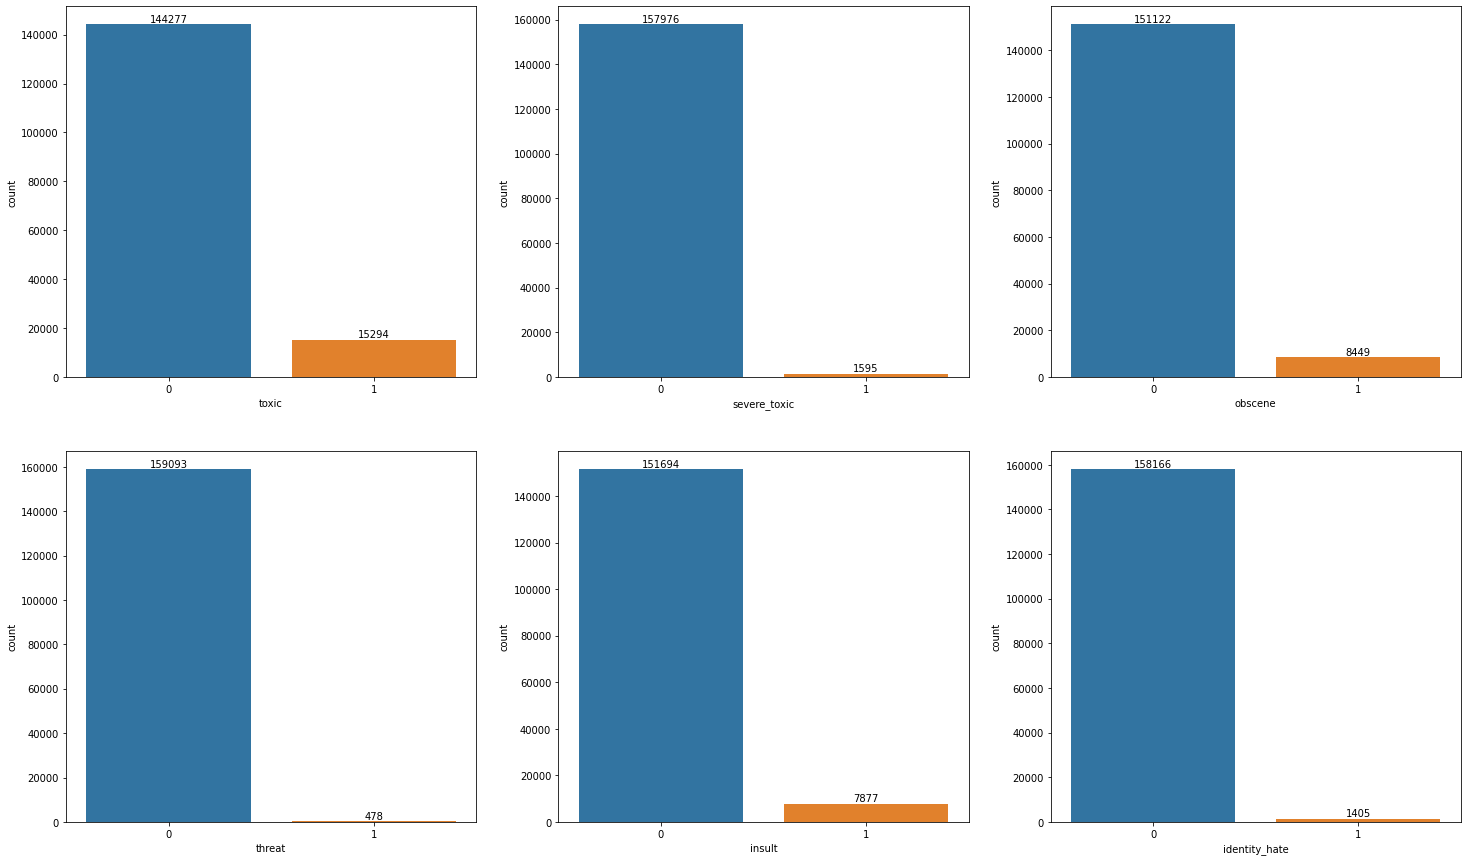

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15))

cols = train_df.select_dtypes(include=np.number)

for col, subplot in zip(cols, ax.flatten()):
    sns.countplot(x=train_df[col], ax=subplot)
    for p in subplot.patches:
        x_ = p.get_bbox().get_points()[:,0]
        y_ = p.get_bbox().get_points()[1,1]
        subplot.annotate(p.get_height(), (x_.mean(), y_), ha='center', va='bottom')
        
plt.show()

## **3. Text Preprocessing**

#### **3.1 Remove URLs**

In [17]:
def remove_urls(text):
    return re.sub(r'https?:\/\/\S*', '', text, flags=re.MULTILINE)

#### **3.2 Remove Emails and Mentions**

In [18]:
def remove_emails_and_mentions(text):
    return re.sub(r'\S*@\S+', '', text, flags=re.MULTILINE)

#### **3.3 Remove Hashtags**

In [19]:
def remove_hashtags(text):
    return re.sub(r'#\S+', '', text, flags=re.MULTILINE)

#### **3.4 Remove HTML tags**

In [20]:
def remove_html_tags(text):
    return re.sub(r'<+.*>+', '', text, flags=re.MULTILINE)

#### **3.5 Remove whitespaces**

In [21]:
def remove_whitespaces(text):
    return text.strip()

#### **3.6 Convert text to lower case**

In [22]:
def to_lowercase(text):
    return text.lower()

#### **3.7 Remove all special characters**

In [23]:
def remove_special_chars(text):
    return re.findall(r'[a-z]{3,}', text)

#### **3.8 Remove stopwords**

In [24]:
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

#### **3.9 Lemmatization**

In [25]:
def lemmatization(words):
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(word) for word in words)

#### **Putting all the pipeline together**

In [26]:
def text_preprocessing(text):
    text = remove_urls(text)
    text = remove_emails_and_mentions(text)
    text = remove_hashtags(text)
    text = remove_html_tags(text)
    text = remove_whitespaces(text)
    text = to_lowercase(text)
    words = remove_special_chars(text)
    words = remove_stopwords(words)
    text = lemmatization(words)
    return text

#### **Applying text preprocessing on train and test sets**

In [27]:
train_df.comment_text = train_df.comment_text.apply(text_preprocessing)

In [28]:
test_df.comment_text = test_df.comment_text.apply(text_preprocessing)

#### **Showing a sample of data after cleaning**

In [29]:
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired,0,0,0,0,0,0
000103f0d9cfb60f,aww match background colour seemingly stuck thanks talk january utc,0,0,0,0,0,0
000113f07ec002fd,hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info,0,0,0,0,0,0
0001b41b1c6bb37e,make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format date format etc later one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form wikipedia good article nomination,0,0,0,0,0,0
0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


In [30]:
test_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00001cee341fdb12,bitch rule succesful ever whats hating sad mofuckas bitch slap pethedic white face get kiss as guy sicken rule pride music man dont dis shit nothin wrong bein like tupac brother fuckin white boy get thing right next time,-1,-1,-1,-1,-1,-1
0000247867823ef7,rfc title fine imo,-1,-1,-1,-1,-1,-1
00013b17ad220c46,source zawe ashton lapland,-1,-1,-1,-1,-1,-1
00017563c3f7919a,look back source information updated correct form guess source updated shall update information thank message,-1,-1,-1,-1,-1,-1
00017695ad8997eb,anonymously edit article,-1,-1,-1,-1,-1,-1
